In [1]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from numpy import array
from numpy import hstack

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%config InlineBackend.figure_formatrmat = 'retina'

In [3]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data

from stesml.model_tools import get_h_from_T_results

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error
from stesml.plot_tools import plot_progress_results

from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_Ac
from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_dT_dt

In [4]:
from sklearn.model_selection import RepeatedKFold

In [5]:
%load_ext tensorboard

In [6]:
import datetime

In [7]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [9]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [10]:
train_index, test_index = get_train_and_test_index(scenario_index, random_state=5)

In [11]:
def get_short_data(X, y, t):
    X = pd.DataFrame(X)
    indexes = X[0] > t
    X = X[indexes]
    y = y[indexes]
    return X, y

In [12]:
def get_train_and_test_data(scenario_index, train_index, test_index, target='Tavg', scale=False, t=0):
    X_train, y_train = get_train_data(scenario_index, train_index, test_index, target=target)
    X_test, y_test = get_test_data(scenario_index, test_index, target=target)
    if t > 0:
        X_train, y_train = get_short_data(X_train, y_train, t)
        X_test, y_test = get_short_data(X_test, y_test, t)
    if scale:
        scaler_x = StandardScaler().fit(X_train)
        X_train = scaler_x.transform(X_train)
        X_test = scaler_x.transform(X_test)  

        scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
        y_train = scaler_y.transform(y_train.reshape(-1,1)).reshape(1,-1)[0]
        y_test = scaler_y.transform(y_test.reshape(-1,1)).reshape(1,-1)[0] 
        return X_train, y_train, X_test, y_test, scaler_x, scaler_y
    return X_train, y_train, X_test, y_test

In [13]:
def build_model():
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(3,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.build()
    #model.summary()
    return model

In [14]:
target = 'Tavg'
scale = True

In [15]:
n_shuffles = 1

r2_tot = 0
rmse_tot = 0

for i in range(n_shuffles):
    train_index, test_index = get_train_and_test_index(scenario_index)
    if scale:
        X_train, y_train, X_test, y_test, scaler_x, scaler_y = get_train_and_test_data(scenario_index, train_index, test_index, target, scale, t=0)
    else:
        X_train, y_train, X_test, y_test = get_train_and_test_data(scenario_index, train_index, test_index, target, scale, t=0)
    model = build_model()
    model.fit(x=X_train, 
          y=y_train,
          batch_size=30,
          epochs=1,
          validation_data=(X_test, y_test), 
          callbacks=[tensorboard_callback])
    y_hat = model.predict(X_test)
    if scale:
        y_hat = scaler_y.inverse_transform(y_hat.reshape(-1,1)).reshape(1,-1)[0]
        y_test = scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]
    r2 = r2_score(y_test, y_hat)
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    
    print('RMSE: {rmse:.4f}, r2: {r2:.4f}'.format(rmse=rmse,r2=r2))
    
    r2_tot += r2
    rmse_tot += rmse
    
    r2_avg = r2_tot/(i+1)
    rmse_avg = rmse_tot/(i+1)
    
    print('RMSE AVG: {rmse_avg:.4f}, r2 AVG: {r2_avg:.4f}'.format(rmse_avg=rmse_avg,r2_avg=r2_avg))

2022-06-27 12:57:14.728661: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 12:57:14.729094: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


Train on 1448622 samples, validate on 360627 samples
   2070/1448622 [..............................] - ETA: 11:46 - loss: 0.1860

2022-06-27 12:57:15.716574: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


1448622/1448622 [==============================] - 93s 64us/sample - loss: 3.8386e-04 - val_loss: 0.0046
RMSE: 2.8520, r2: 0.9932
RMSE AVG: 2.8520, r2 AVG: 0.9932


In [16]:
test_df = load_data(scenario_index, test_index)

In [17]:
test_df[target+"_hat"] = y_hat

In [18]:
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent=False, target=target)

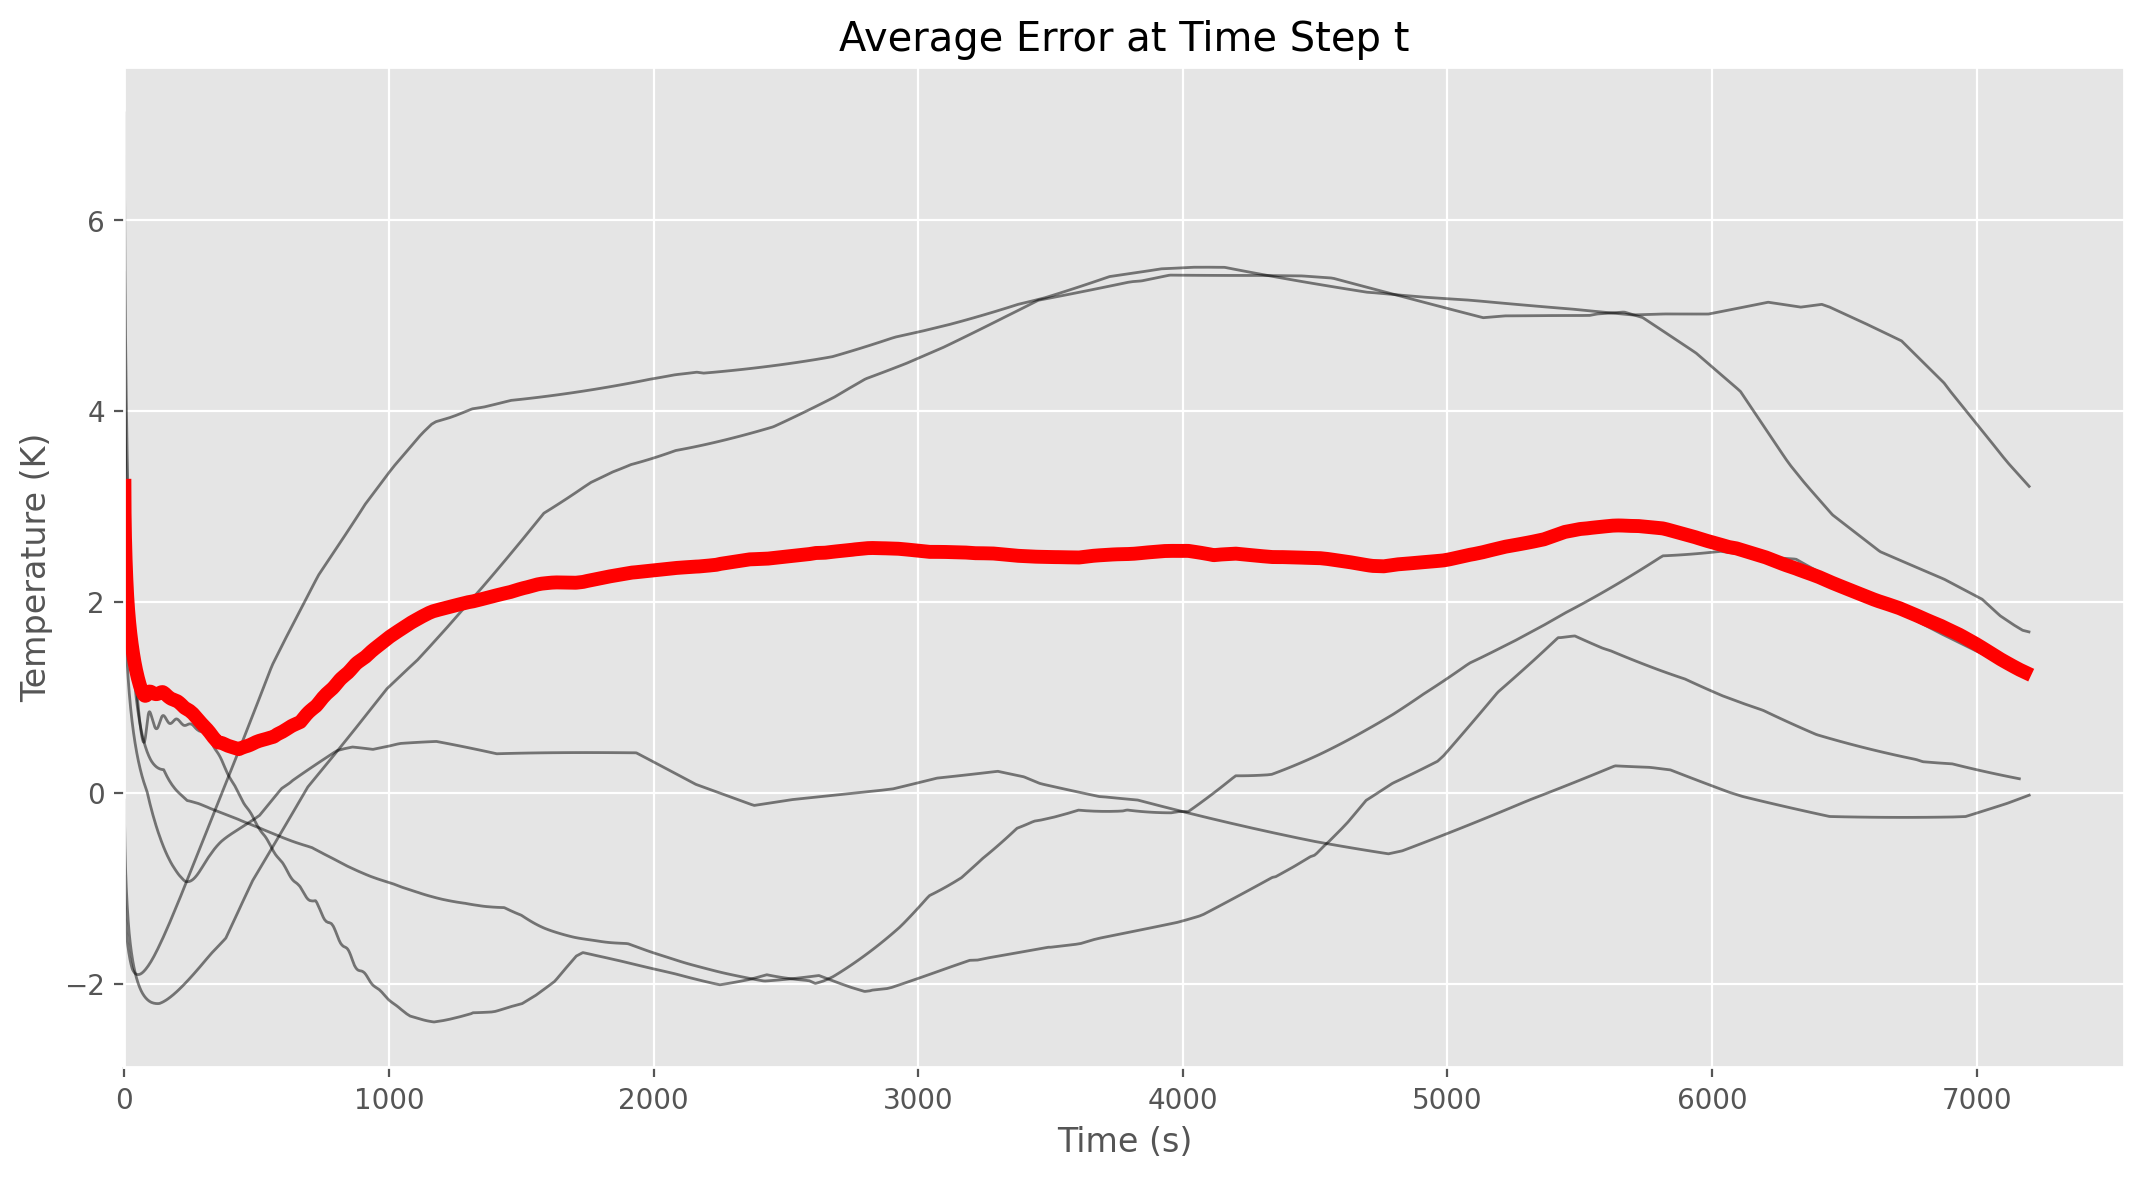

In [19]:
plot_average_error(test_df_plot, target=target)

<AxesSubplot:>

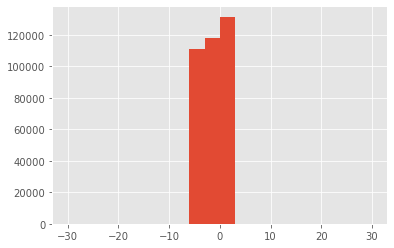

In [20]:
(test_df_plot[target] - test_df_plot[target+'_hat']).hist(bins=20, range=(-30, 30))

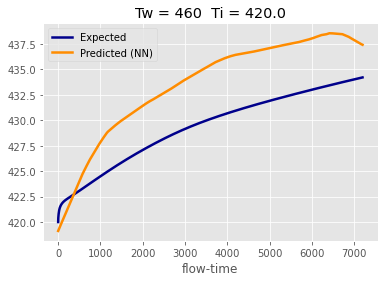

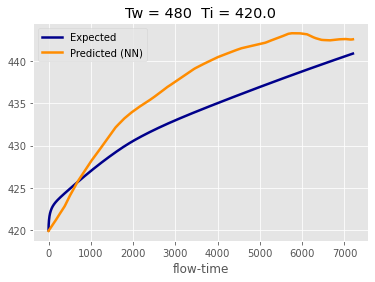

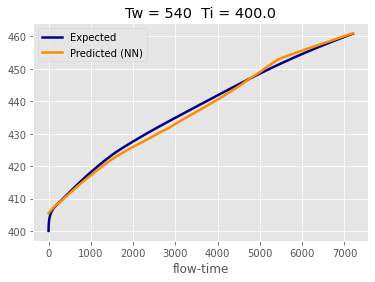

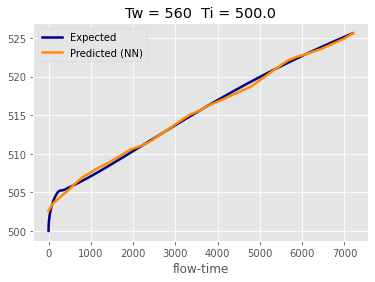

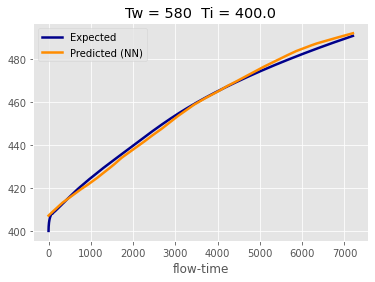

In [21]:
plot_test_results(test_df_plot, model_type='NN', target=target)

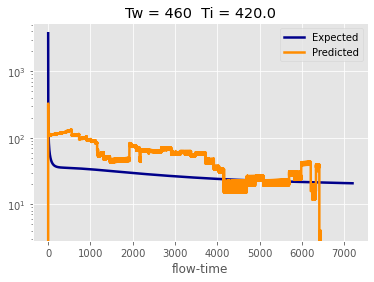

/Users/kmenear/Projects/envTFsulfurTES/lib/python3.7/site-packages/stesml-0+unknown-py3.7.egg/stesml/postprocessing_tools.py:53: RuntimeWarning: invalid value encountered in true_divide


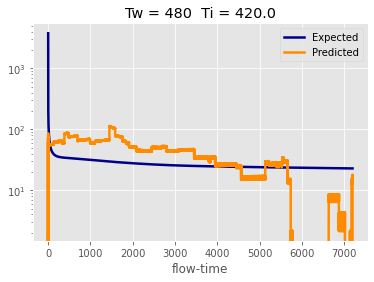

/Users/kmenear/Projects/envTFsulfurTES/lib/python3.7/site-packages/stesml-0+unknown-py3.7.egg/stesml/postprocessing_tools.py:53: RuntimeWarning: invalid value encountered in true_divide


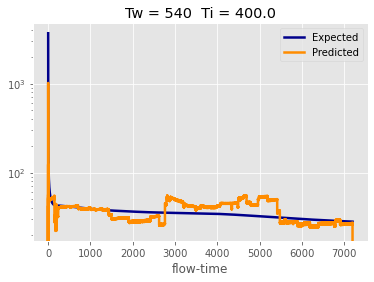

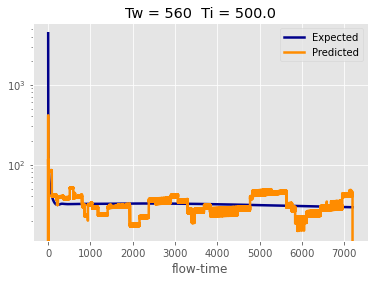

/Users/kmenear/Projects/envTFsulfurTES/lib/python3.7/site-packages/stesml-0+unknown-py3.7.egg/stesml/postprocessing_tools.py:53: RuntimeWarning: invalid value encountered in true_divide


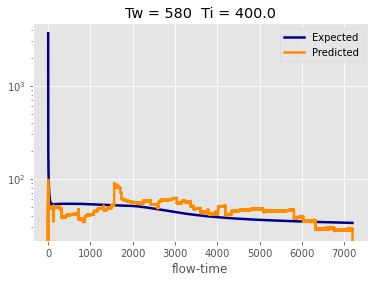

In [22]:
if target == 'Tavg:
    rmse, r2 = get_h_from_T_results(test_df, plot=True)
else:
    rmse, r2 = get_T_from_h_results(test_df, plot=True)

In [23]:
print(rmse)

58.64151270380233


In [24]:
print(r2)

-0.09341272897010255
